In this notebook the entropy of systems harboring Majorana zero modes is calculated. 

To know more about entropy in Majorana systems the following references are recommended:

- Detecting the Universal Fractional Entropy of Majorana Zero Modes, [Sela et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.147702)

- Majorana tunneling entropy, [Smirnov](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.195312)

- Direct entropy measurement in a mesoscopic quantum system, [Hartman et al.](https://www.nature.com/articles/s41567-018-0250-5)

- A Robust Protocol for Entropy Measurement in Mesoscopic Circuits, [Child et al.](https://www.mdpi.com/1099-4300/24/3/417)

- How to measure the entropy of a mesoscopic system via thermoelectric transport, [Kleeorin et al.](https://www.nature.com/articles/s41467-019-13630-3)


# Outline
- [1 - Intro and definitions](#1)
- [2 - Entropy in the Kitaev chain](#2)
  - [2.1 Local computation for small systems](#2.1)
  - [2.2 External computation for larger systems](#2.2)
- [3 - Entropy in ferromagnetic-superconducting nanowires](#3)
  - [3.1 Local computation for small systems](#3.1)
  - [3.2 External computation for larger systems](#3.2)
- [4 - Supplement](#4)
  - [4.1 Rashba nanowire within tight binding](#4.1)

<a name="1"></a>
# Intro and definitions

In quantum dot systems coupled to electronic reservoirs changes in entropy have been indirectly measured in setups able to detect small changes in charge, [Hartman et al.](https://www.nature.com/articles/s41567-018-0250-5) and [Child et al.](https://www.mdpi.com/1099-4300/24/3/417) The entropy measurement is based on the Maxwell relation

$$\frac{\partial S}{\partial \mu} \Biggr|_T=\frac{\partial N}{\partial T} \Biggr|_{\mu},$$

which connects the ratio of changes in entropy and chemical potential with the ratio of changes in charge and temperature.

### Under construction

In [2]:
import kwant
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import adaptive
adaptive.notebook_extension()  # This is to enable the notebook integration
from functools import partial
import h5py
import matplotlib.pyplot as plt

<a name="2"></a>
# Entropy in the Kitaev chain

## Local computation for small systems

In [3]:
paulix = np.array([[0,1],[1,0]])
pauliy = np.array([[0,-1j],[1j,0]])
pauliz = np.array([[1,0],[0,-1]])

In [4]:
def Kitaev_syst(aa, LN, LS):
    
    def interval_shape(pos):
        x, = pos
        return  -LN <= x <= LS 
    
    def onsite(site, mu_sc, mu_n):
        (x,) = site.pos
        if x >= 0:
            return -mu_sc*pauliz
        if x < 0:
            return -mu_n*pauliz
    
    def hop(site1, site2, t, Delta, V):
        (x,) = site1.pos
        if x > 0:
            return -t*pauliz  - 1j*Delta*pauliy
        elif x < 0:
            return -t*pauliz  
        elif x == 0:
            return -V*pauliz
    
    lat = kwant.lattice.chain(aa,norbs=2)
    syst = kwant.Builder()
    syst[lat.shape(interval_shape, (0, ))] = onsite
    syst[lat.neighbors()] = hop
    syst = syst.finalized()
    
    return syst

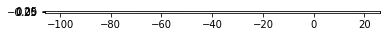

Plotting the nodes and vertices of the lattice


In [5]:
Ln = 100.0
Ls = 20.0
alat = 0.4
syst_one = Kitaev_syst(alat,Ln,Ls)
kwant.plot(syst_one)
print('Plotting the nodes and vertices of the lattice')

In [6]:
params = dict(t=1,mu_sc=0.2,mu_n=0.0,Delta=1.5, V=5)

In [7]:
ham = syst_one.hamiltonian_submatrix(params=params, sparse=False)

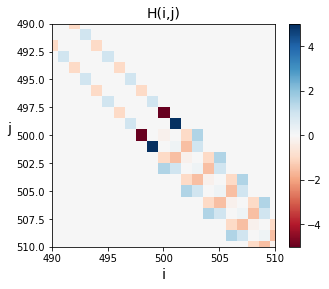

In [8]:
#lattice index corresponding to x=0
n_0 = int(Ln/alat)
#number of sites around x=0
mm = 10

fig, sub = plt.subplots(1, figsize=(5,5))
imshow_kwargs = {
    'origin': 'lower',
    'cmap': 'RdBu',
}
aa = sub.imshow(ham[::,::].real, **imshow_kwargs)
sub.set_xlim(2*n_0-mm,2*n_0+mm)
sub.set_ylim(2*n_0+mm,2*n_0-mm)
sub.set_xlabel('i', fontsize=14)
sub.set_ylabel('j', fontsize=14, rotation='horizontal', labelpad=7)
sub.set_title('H(i,j)', fontsize=14)
cbar = fig.colorbar(aa, ax=sub, shrink=0.82)

In [9]:
syst_one.hamiltonian(i=250,j=249, params=params)

array([[-5,  0],
       [ 0,  5]])

In [10]:
def E_wvf(syst,mu, supgap, Varr, Va, nn,nrts):
  
    if Va < Varr[0] or Va > Varr[-1]:
        ia = 0
    else:
        ia = (Va - Varr[0])/(Varr[1]-Varr[0])
        ia = int(round(ia))
        
    if abs(nn) > 0.5*nrts:
        nn = int(np.sign(nn)*0.5*nrts)

    Elist = []
    indlist = [ia]
    ttlist = ['(a)','(b)','(c)']
    vlist = []
    indx_states = [0,nn]
    colorlist = ['r','m']
    symbolist = ['o','s']
    
    params['mu_sc'] = mu
    params['Delta'] = supgap
    
    for ii, Vv in enumerate(Varr):
        params['V'] = Vv
        ham = syst.hamiltonian_submatrix(params=params,sparse=True)
        if ii == ia:
            Evals, Evecs = eigsh(ham, k=nrts, which='SM')
            indarr = np.argsort(Evals)
            Evals = Evals[indarr]
            vlist.append(Evecs[::,indarr])
            h_site_dim = len(syst.hamiltonian(i=0,j=1, params=params))
        else: 
            Evals = eigsh(ham, k=nrts, which='SM', return_eigenvectors=False)
            Evals = np.sort(Evals)
            
        Elist.append(Evals)
    
    Emtx = np.array(Elist)
    rho = kwant.operator.Density(syst, np.eye(h_site_dim))
    
    lat_arr= np.arange(-Ln,Ls+alat,alat)

    fig, sub = plt.subplots(1,3, figsize=(13,4))
    
    Edw = 0.4*Emtx[0,0]; Eup = 0.4*Emtx[0,-1] 
    sub[0].plot(Varr, Emtx)
    sub[0].plot(Varr[ia]*np.ones(7),np.linspace(Edw,Eup,7), '--k', alpha=0.5)
    sub[0].set_ylim(Edw,Eup)
    sub[0].set_xlabel(r'$V$')
    sub[0].set_ylabel(r'$E$', rotation='horizontal')
    sub[0].set_title(ttlist[0])
    nhlf = int(0.5*nrts)
    for jj in range(2):
        sub[1+jj].set_xlabel('x')
        sub[1+jj].set_ylabel(r'$|\psi\,|^2$', rotation='horizontal', labelpad=8, y=0.48)
        
        En = Emtx[ia,nhlf+indx_states[jj]]
        sub[1+jj].plot(lat_arr,rho(vlist[0][::,nhlf+indx_states[jj]]), color=colorlist[jj], 
                       label='E='+str.format('{:.3f}',En))
        sub[0].plot(Varr[ia],En, marker=symbolist[jj], color=colorlist[jj], markersize=10, 
                    fillstyle='left')
        psi_Majo_max = np.max(rho(vlist[0][::,nhlf]))
        sub[1+jj].set_xlim(-Ls, Ls)
        sub[1+jj].set_ylim(-0.05*psi_Majo_max, 1.05*psi_Majo_max)
        sub[1+jj].set_title(ttlist[1+jj]+r'$\;E=$'+str.format('{:.3f}',En))
    
    sub[1].text(0.3*Ls, 0.9*psi_Majo_max, r'$\mu=$'+str.format('{:.2f}',mu), fontsize=11)
    sub[1].text(0.3*Ls, 0.79*psi_Majo_max, r'$\Delta=$'+str.format('{:.2f}',supgap), fontsize=11)
    sub[1].text(0.3*Ls, 0.68*psi_Majo_max, r'$V=$'+str.format('{:.2f}',Varr[ia]), fontsize=11)
    
    fig.subplots_adjust(wspace=0.25)

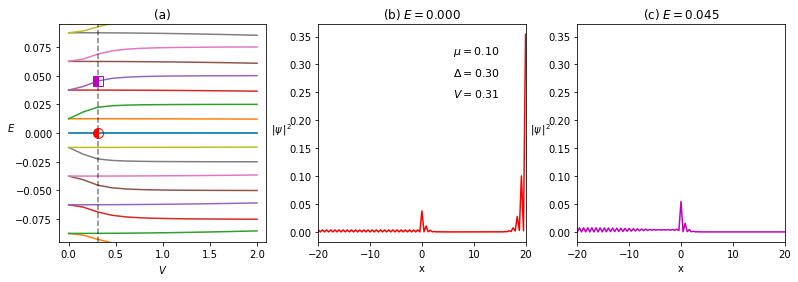

In [11]:
sc_mu = 0.1
sc_gap = 0.3
arrV = np.linspace(0,2.0,14)
V_linecut = 0.3
n_state = 4
n_roots = 40
E_wvf(syst_one, sc_mu,sc_gap, arrV,V_linecut,n_state,n_roots)

In [12]:
params['Delta'] = 1.5

In [13]:
Varr = np.linspace(0.0,1,2)

Enlist = []
for Vv in Varr:
    params['V'] = Vv
    ham = syst_one.hamiltonian_submatrix(params=params, sparse=False)
    evals = eigh(ham, eigvals_only=True)
    evals = np.sort(evals)
    print('Number of eigenvalues: ',len(evals))
    Enlist.append(evals)

Number of eigenvalues:  602
Number of eigenvalues:  602


To estimate the level spacing of the spinless 1D reservoir, let's consider the hamiltonian of a periodic 1D chain in the low $k$ limit, 
$$H_0 = -2t\cos{ka} \approx -2t + ta^2 k^2.$$
Eigenstates of this hamiltonian are the standard linear combination of plane waves propagating to the left and right, $\psi(x) = Ae^{ikx} + Be^{-ikx}$. From boundary conditions $\psi(0)=\psi(L)=0$, we obtain that $k= n\pi/L$, where $n$ is an integer, and the energy $E_n=t\bigl(\frac{a^2\pi^2}{L^2}n^2 -2\bigl)$. The level spacing reads,

$$E_{n+1} - E_n = \frac{ta^2\pi^2}{L^2}(2n+1)=t\frac{2\pi a}{L}\Bigl(\sqrt{\frac{E}{t}+2}+\frac{\pi a}{2L}\Bigr).$$

From last expression we can take the energy-independent value $\frac{2\pi at}{L}$ as a reasonable reference for the level spacing.

In [14]:
def level_spacing(En, nwide=None, dE_pred=None, dE_func=None, npts=None, ax=None):
    dEn = En - np.roll(En,1) 
    nhlf = int(0.5*len(En))
    
    if nwide:
        nsts = nwide
    else:
        nsts = 80
    
    if dE_pred:
        Earr_red = np.linspace(En[nhlf-nsts],En[nhlf+nsts],7)
        if ax:
            ax.plot(Earr_red,dE_pred*np.ones(7), '--k')        
        else:
            plt.plot(Earr_red,dE_pred*np.ones(7), '--k')        

    if npts:
        npoints = npts
    else:
        npoints = 10
        
    if dE_func:
        E1,dE_branch1 = shift_Efunc(npoints)
        E2 = -E1
        if ax:
            ax.plot(E1,dE_branch1, lw=2.5)
            ax.plot(E2,dE_branch1, lw=2.5)
        else:    
            plt.plot(E1,dE_branch1, lw=2.5)
            plt.plot(E2,dE_branch1, lw=2.5)
        
    if ax:
        ax.plot(En[nhlf-nsts:nhlf+nsts:],dEn[nhlf-nsts:nhlf+nsts:],'-o', color='C0')
        return ax
    else:        
        plt.plot(En[nhlf-nsts:nhlf+nsts:],dEn[nhlf-nsts:nhlf+nsts:],'-o', color='C0')
        plt.xlabel('Energy', fontsize=12)
        plt.ylabel('Level spacing '+r'$(E_{i+1}-E_i)$', fontsize=12)


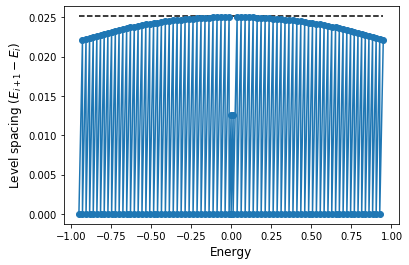

In [15]:
d_spacing_theory = 2*np.pi*params.get('t')*alat/Ln
level_spacing(En=Enlist[0], dE_pred=d_spacing_theory)

In [16]:
def entropy(TT,Earr):
    
    nhlf = int(0.5*len(Earr[::]))
    #print(nhlf)
    listone = [np.log(1 + np.exp(-En/TT)) for En in Earr[nhlf::] ]
    listtwo = [En*np.exp(-En/TT)/(1 + np.exp(-En/TT))/TT for En in Earr[nhlf::] ]
    Esumon = np.sum(np.array(listone))
    Esumtw = np.sum(np.array(listtwo))
    return Esumon + Esumtw

In [17]:
def S_diff(Earr,Earref,TT):
    out = entropy(TT,Earr) - entropy(TT,Earref)
    return out

In [18]:
Stoadapt = partial(S_diff, Enlist[1],Enlist[0])

In [19]:
Stoadapt(1e-3)

-4.8789545303851156e-05

In [20]:
Tlow = 1e-3; Thigh=4e0
learner = adaptive.Learner1D(Stoadapt, bounds=(Tlow,Thigh))
runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 0.04)
runner.live_info()

In [27]:
learner.plot()

In [21]:
def get_data_sorted(learner):
    bb = learner.data
    keys = list(bb.keys())
    values = list(bb.values())

    indexes = np.argsort(np.array(keys))
    sorted_keys = np.array(np.sort(np.array(keys)))
    sorted_output = np.array([values[k] for k in indexes])
    return sorted_keys, sorted_output

In [22]:
keys, output = get_data_sorted(learner)

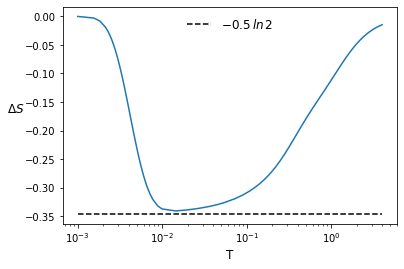

In [23]:
Tfewpoints = np.linspace(Tlow,Thigh,7)
plt.plot(keys, output)
plt.xscale('log')
plt.plot(Tfewpoints,-0.5*np.log(2)*np.ones(len(Tfewpoints)), '--k', label=r'$-0.5\,ln\, 2$')
plt.xlabel('T', fontsize=12)
plt.ylabel(r'$\Delta S$', fontsize=12, rotation='horizontal', labelpad=9)
plt.legend(frameon=False, fontsize=12)

## External computation for larger systems

In [24]:
path = './data/entropy/V_0_1.8/'
fl_prefix = '/EE_V_0.0_1.4_mu_sc-0.2_xi'
fl_suffix = '_xf40.0.hdf5'
Lnarr = np.linspace(800,1000,3)

#list with paths to the files
fls_list = [path+'Ln_'+str.format('{:.0f}',Lnormal)+fl_prefix+str.format('{:.1f}',-Lnormal)+fl_suffix for Lnormal in Lnarr]
#list with the energy files
fls = [h5py.File(name, 'r') for name in fls_list]
fls_list

['./data/entropy/V_0_1.8/Ln_800/EE_V_0.0_1.4_mu_sc-0.2_xi-800.0_xf40.0.hdf5',
 './data/entropy/V_0_1.8/Ln_900/EE_V_0.0_1.4_mu_sc-0.2_xi-900.0_xf40.0.hdf5',
 './data/entropy/V_0_1.8/Ln_1000/EE_V_0.0_1.4_mu_sc-0.2_xi-1000.0_xf40.0.hdf5']

In [25]:
Enlist = [np.array(ee.get('array_2')) for ee in fls ]
xlist = [ff.get('array_1') for ff in fls]

In [26]:
for ii in range(len(fls_list)):
    ntot = len(Enlist[ii][0,:])
    nhlf = int(0.5*ntot)
    print('total (half) number of energies: ',ntot,'(',nhlf,')')

total (half) number of energies:  4202 ( 2101 )
total (half) number of energies:  4702 ( 2351 )
total (half) number of energies:  5202 ( 2601 )


Text(0, 0.5, 'Energy')

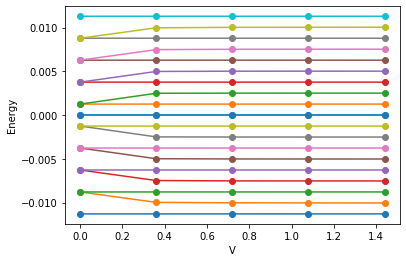

In [27]:
plt.plot(xlist[2],Enlist[2][::,nhlf-10:nhlf+10:], '-o')
plt.xlabel('V')
plt.ylabel('Energy')

Text(0, 0.5, 'Level spacing $(E_{i+1}-E_i)$')

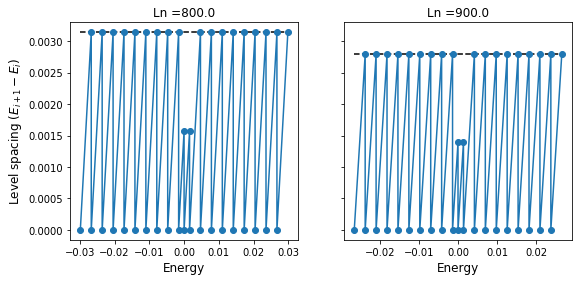

In [28]:
fig, sub = plt.subplots(1,2, sharey=True, figsize=(9,4))

for ii in range(2):
    d_spacing_theory = 2*np.pi*params.get('t')*alat/Lnarr[ii]
    sub[ii] = level_spacing(En=Enlist[ii][0,::], nwide=20, dE_pred=d_spacing_theory, ax=sub[ii])
    sub[ii].set_title('Ln ='+str(Lnarr[ii]))
    sub[ii].set_xlabel('Energy', fontsize=12)
    
sub[0].set_ylabel('Level spacing '+r'$(E_{i+1}-E_i)$', fontsize=12)

In [29]:
def S_lplots(A,TT):
    n_pick = 0
    Slist = []
    
    for ii in range(1,len(A[0])):
        Slist.append(S_diff(A[n_pick][ii,::], A[n_pick][0,::], TT))
        
    for jj in range(len(A)):
        Slist.append(S_diff(A[jj][-1,::], A[jj][0,::], TT))
        
    return np.array(Slist)

In [30]:
Stoadapt = partial(S_lplots, Enlist)

In [31]:
Stoadapt(1e-3)

array([-0.32296236, -0.32605276, -0.32658245, -0.3267185 , -0.3267185 ,
       -0.33609858, -0.3411011 ])

In [32]:
Tlow = 2e-4; Thigh=5e0
learner = adaptive.Learner1D(Stoadapt, bounds=(Tlow,Thigh))
runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 0.03)
runner.live_info()

In [59]:
learnentro.plot()

In [33]:
keys, output = get_data_sorted(learner)

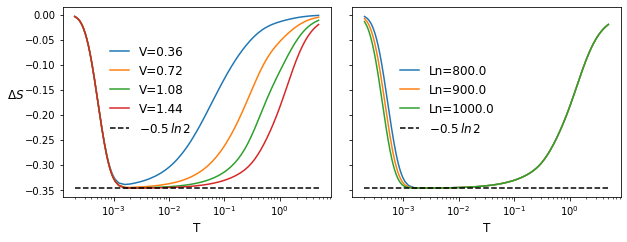

In [34]:
Tfewpoints = np.linspace(Tlow,Thigh,7)
fig, sub = plt.subplots(1,2, sharey=True, figsize=(10,3.5))

max_nV = len(xlist[0])
#for ii in range(len(sorted_output_discr[0,::])):
for ii in range(7):
    if ii < max_nV-1:
        sub[0].plot(keys, output[::,ii], label = 'V='+str(xlist[0][ii+1]))
    else:
        sub[1].plot(keys, output[::,ii], label = 'Ln='+str(Lnarr[ii-max_nV+1]))
    
    
#sub[1].plot(Tfewpoints,-np.log(2)*np.ones(len(Tfewpoints)), '--b', label=r'$-ln\, 2$')
for ii in range(2):    
    sub[ii].set_xscale('log')
    sub[ii].plot(Tfewpoints,-0.5*np.log(2)*np.ones(len(Tfewpoints)), '--k', label=r'$-0.5\,ln\, 2$')
    sub[ii].set_xlabel('T', fontsize=12)
    #sub[ii].set_xlim(7e-4,2e-3)
    sub[ii].legend(loc=(0.16,0.3), frameon=False, fontsize=12, ncol=1, handlelength=1.6)    

sub[0].set_ylabel(r'$\Delta S$', fontsize=12, rotation='horizontal', labelpad=9)
fig.subplots_adjust(wspace=0.08)    

<a name="3"></a>
# Entropy in ferromagnetic-superconducting nanowires

Within tight binding, the hamiltonian for a Rashba nanowire with proximity-induced superconductivity and ferromagnetism reads, [see [Szumniak et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.041401)]    

\begin{eqnarray}
\sum_{j=1}^{N-1} \bigl[C^{\dagger}_{j+1}\bigl(-t -i\tilde{\alpha}\sigma_z\bigr)\tau_z C_j 
+ C_j\bigl(-t +i\tilde{\alpha}\sigma_z\bigr)\tau_z C^{\dagger}_{j+1}\bigr]
+ \sum_{j=1}^N C^{\dagger}_j\bigl[\bigl(2t - \mu\bigr)\tau_z + \Delta_0\tau_x + \mathbf{m}_i\cdot\boldsymbol{\sigma}\bigr]C_j,
\end{eqnarray}

where $t$ is the hopping, $\tilde{\alpha}$ the spin-flip hopping, $\mu$ the chemical potential, $\Delta_0$ the proximity-induced superconducting gap, $\mathbf{m}_i=(m_{x,i},m_{y,i},m_{z,i})$, the proximity-induced magnetization,  $C_j=\bigl(c_{j\uparrow},c_{j\downarrow},c_{j\downarrow}^{\dagger},-c_{j\uparrow}^{\uparrow}\bigr)^T$, and $\boldsymbol{\sigma}=(\sigma_x,\sigma_y,\sigma_z)$ and $\boldsymbol{\tau}=(\tau_x,\tau_y,\tau_z)$ are Pauli matrices in the spin and Nambu spaces, respectively.

In [4]:
taux4 = np.kron(paulix, np.eye(2))
tauz4 = np.kron(pauliz, np.eye(2))
sz_tauz = np.kron(pauliz, pauliz)
sy_tauz = np.kron(pauliz, pauliy)

sx4 = np.kron(np.eye(2), paulix)
sy4 = np.kron(np.eye(2), pauliy)
sz4 = np.kron(np.eye(2), pauliz)

In [36]:
def FS_NW_syst(aa,LN,LS):

    
    def interval_shape(pos):
        x, = pos
        return  -LN <= x <= LS 

    def onsite(site, t, mu_sc, mu_n, Delta, m0, theta, phi, V):
        (x,) = site.pos
        if x >= 0:
            mx = m0*np.sin(theta*np.pi)*np.cos(phi*np.pi)
            my = m0*np.sin(theta*np.pi)*np.sin(phi*np.pi)
            mz = m0*np.cos(theta*np.pi)
            H_mag = mx*sx4 + my*sy4 + mz*sz4
            H_sc = Delta*taux4 
            H_chem = (2*t-mu_sc)*tauz4 
            return H_chem + H_sc + H_mag
        elif x < -aa:
            return (2*t-mu_n)*tauz4
        elif -1.1*aa < x <-0.9*aa:
            return V*tauz4

    def hop(site1, site2, t, alpha):
        return -t*tauz4 -1j*alpha*sz_tauz

    lat = kwant.lattice.chain(aa,norbs=4)
    syst = kwant.Builder()
    syst[lat.shape(interval_shape, (0, ))] = onsite
    syst[lat.neighbors()] = hop
    syst = syst.finalized()

    return syst

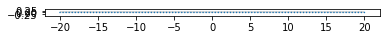

Plotting the nodes and vertices of the lattice


In [37]:
Ln = 20.0
Ls = 20.0
alat = 0.4
syst_two = FS_NW_syst(alat,Ln,Ls)
kwant.plot(syst_two)
print('Plotting the nodes and vertices of the lattice')

In [38]:
params = dict(t=2.0, alpha=1, Delta=2.0, mu_n=0.0, V=0, mu_sc=0.0, 
                       m0=3.0, theta=0.5, phi=0.0)

In [39]:
syst_two.hamiltonian(i=0,j=1, params=params)

array([[-2.+1.j, -0.-0.j, -0.-0.j, -0.-0.j],
       [-0.-0.j, -2.-1.j, -0.-0.j, -0.-0.j],
       [-0.-0.j, -0.-0.j,  2.-1.j,  0.-0.j],
       [-0.-0.j, -0.-0.j,  0.-0.j,  2.+1.j]])

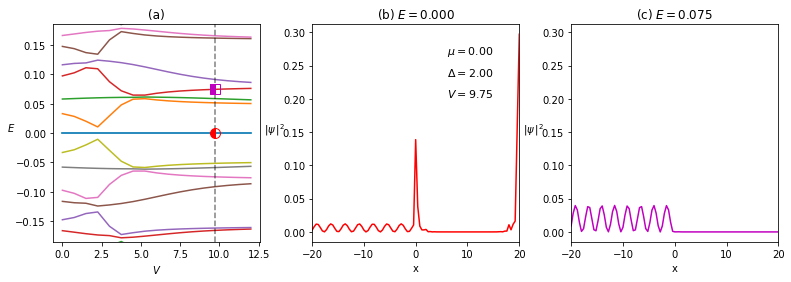

In [40]:
sc_mu = 0.0  #3.0
sc_gap = 2.0
arrV = np.linspace(0.0,12.0,17)
V_linecut = 10.0
n_state = 3
n_roots = 40
E_wvf(syst_two,sc_mu,sc_gap, arrV,V_linecut,n_state,n_roots)

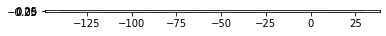

Plotting the nodes and vertices of the lattice


In [41]:
Ln = 140.0
Ls = 30
alat = 0.4
syst_two = FS_NW_syst(alat,Ln,Ls)
kwant.plot(syst_two)
print('Plotting the nodes and vertices of the lattice')

In [42]:
params['Delta'] = 5.0
params['m0'] = 8.0

In [43]:
Varr = np.linspace(0.0,20.0,17)

Enlist = []
for Vv in Varr:
    params['V'] = Vv
    ham = syst_two.hamiltonian_submatrix(params=params, sparse=False)
    evals = eigh(ham, eigvals_only=True)
    evals = np.sort(evals)
    Enlist.append(evals)

Text(0, 0.5, 'E')

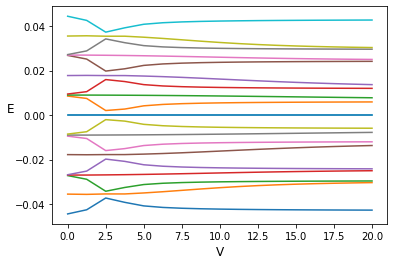

In [44]:
Emtx = np.array(Enlist)
nhlf = int(0.5*len(Emtx[0,:]))
plt.plot(Varr,Emtx[::,nhlf-10:nhlf+10:])
plt.xlabel('V', fontsize=12)
plt.ylabel('E', fontsize=12, rotation='horizontal')

In [45]:
def shift_Efunc(npoints):
    
    Eone = []
    Etwo = []
    
    hop = params.get('t')
    chem = params.get('mu_n')
    socoup = params.get('alpha')
    
    ak0 = np.arctan(socoup/hop)
    aa = np.pi*alat/Ln
    
    for ii in range(npoints):
        EE = hop*np.cos(ak0)*(aa*ii-ak0)**2 + 2*(hop*np.sin(ak0)-socoup*np.cos(ak0))*(aa*ii-ak0) +\
        2*hop - chem - 2*(hop*np.cos(ak0) + socoup*np.sin(ak0))
        FF = hop*np.cos(ak0)*(aa*ii+ak0)**2 + 2*(-hop*np.sin(ak0)+socoup*np.cos(ak0))*(aa*ii+ak0) +\
        2*hop - chem - 2*(hop*np.cos(ak0) + socoup*np.sin(ak0))
        Eone.append(EE)
        Etwo.append(FF)
    
    Ear1 = np.array(Eone)
    dEn1 = Ear1 - np.roll(Ear1,1) 
    
    return Ear1[1::], np.abs(dEn1[1::])

Text(0, 0.5, 'Level spacing $(E_{i+1}-E_i)$')

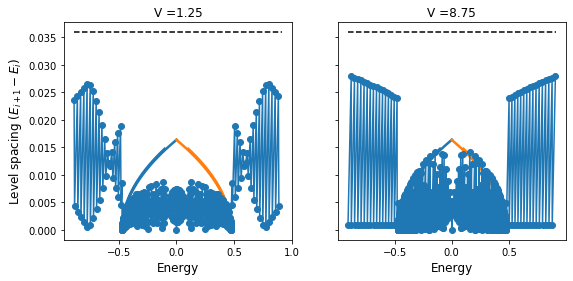

In [49]:
fig, sub = plt.subplots(1,2, sharey=True, figsize=(9,4))

for ii in range(2):
    d_spacing_theory = 2*np.pi*params.get('t')*alat/Ln
    sub[ii] = level_spacing(En=Enlist[6*ii+1], nwide=180, dE_pred=d_spacing_theory, ax=sub[ii],
                           dE_func=shift_Efunc, npts=110)
    sub[ii].set_title('V ='+str(Varr[6*ii+1]))
    sub[ii].set_xlabel('Energy', fontsize=12)
    
sub[0].set_ylabel('Level spacing '+r'$(E_{i+1}-E_i)$', fontsize=12)

In [50]:
Stoadapt = partial(S_diff, Enlist[0],Enlist[-1])

In [51]:
Tlow = 1e-3; Thigh=9e-1
learner = adaptive.Learner1D(Stoadapt, bounds=(Tlow,Thigh))
runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 0.033)
runner.live_info()

In [52]:
keys, output = get_data_sorted(learner)

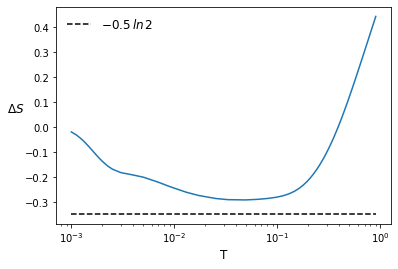

In [53]:
Tfewpoints = np.linspace(Tlow,Thigh,7)
plt.plot(keys, output)
plt.xscale('log')
plt.plot(Tfewpoints,-0.5*np.log(2)*np.ones(len(Tfewpoints)), '--k', label=r'$-0.5\,ln\, 2$')
plt.xlabel('T', fontsize=12)
plt.ylabel(r'$\Delta S$', fontsize=12, rotation='horizontal', labelpad=9)
plt.legend(frameon=False, fontsize=12)

## External computation for larger systems

In [54]:
path = './data/entropy/V_'

lims_one = [0,5]
lims_two = [10,550]
nVs = 5
mVs = 8

fold_one = path+str(lims_one[0])+'_'+str(lims_one[1])+'/'
fold_two = path+str(lims_two[0])+'_'+str(lims_two[1])+'/'

Vone_arr = np.linspace(lims_one[0],lims_one[1],nVs, endpoint=False)
Vtwo_arr = np.linspace(lims_two[0],lims_two[1],mVs, endpoint=False)

flone_prefix = '/FSNW_EE_V_'+str.format('{:.1f}',Vone_arr[0])+'_'+str.format('{:.1f}',Vone_arr[-1])+'_mu_sc0.0_xi'
fltwo_prefix = '/FSNW_EE_V_'+str.format('{:.1f}',Vtwo_arr[0])+'_'+str.format('{:.1f}',Vtwo_arr[-1])+'_mu_sc0.0_xi'

fl_suffix = '_xf60.0.hdf5'

Lnarr = np.linspace(900,1000,5)

#list with paths to the files
list_one = [fold_one+'Ln_'+str.format('{:.0f}',Lnormal)+flone_prefix+str.format('{:.1f}',-Lnormal)+fl_suffix for Lnormal in Lnarr]
list_two = [fold_two+'Ln_'+str.format('{:.0f}',Lnormal)+fltwo_prefix+str.format('{:.1f}',-Lnormal)+fl_suffix for Lnormal in Lnarr]
fls_list = list_one + list_two
#list with the energy files
fls = [h5py.File(name, 'r') for name in fls_list]
fls_list

['./data/entropy/V_0_5/Ln_900/FSNW_EE_V_0.0_4.0_mu_sc0.0_xi-900.0_xf60.0.hdf5',
 './data/entropy/V_0_5/Ln_925/FSNW_EE_V_0.0_4.0_mu_sc0.0_xi-925.0_xf60.0.hdf5',
 './data/entropy/V_0_5/Ln_950/FSNW_EE_V_0.0_4.0_mu_sc0.0_xi-950.0_xf60.0.hdf5',
 './data/entropy/V_0_5/Ln_975/FSNW_EE_V_0.0_4.0_mu_sc0.0_xi-975.0_xf60.0.hdf5',
 './data/entropy/V_0_5/Ln_1000/FSNW_EE_V_0.0_4.0_mu_sc0.0_xi-1000.0_xf60.0.hdf5',
 './data/entropy/V_10_550/Ln_900/FSNW_EE_V_10.0_482.5_mu_sc0.0_xi-900.0_xf60.0.hdf5',
 './data/entropy/V_10_550/Ln_925/FSNW_EE_V_10.0_482.5_mu_sc0.0_xi-925.0_xf60.0.hdf5',
 './data/entropy/V_10_550/Ln_950/FSNW_EE_V_10.0_482.5_mu_sc0.0_xi-950.0_xf60.0.hdf5',
 './data/entropy/V_10_550/Ln_975/FSNW_EE_V_10.0_482.5_mu_sc0.0_xi-975.0_xf60.0.hdf5',
 './data/entropy/V_10_550/Ln_1000/FSNW_EE_V_10.0_482.5_mu_sc0.0_xi-1000.0_xf60.0.hdf5']

In [55]:
Enlist = [np.array(ee.get('array_2')) for ee in fls ]
xlist = [ff.get('array_1') for ff in fls]

In [56]:
nhlf_list = []
for ii in range(len(fls_list)):
    ntot = len(Enlist[ii][0,:])
    nhlf = int(0.5*ntot)
    nhlf_list.append(nhlf)
    print('total (half) number of energies: ',ntot,'(',nhlf,')')

total (half) number of energies:  9604 ( 4802 )
total (half) number of energies:  9852 ( 4926 )
total (half) number of energies:  10104 ( 5052 )
total (half) number of energies:  10352 ( 5176 )
total (half) number of energies:  10604 ( 5302 )
total (half) number of energies:  9604 ( 4802 )
total (half) number of energies:  9852 ( 4926 )
total (half) number of energies:  10104 ( 5052 )
total (half) number of energies:  10352 ( 5176 )
total (half) number of energies:  10604 ( 5302 )


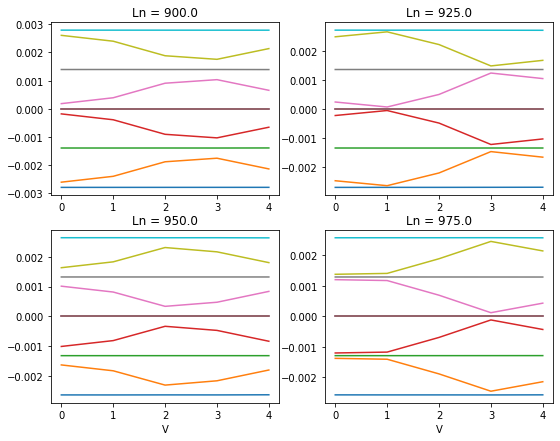

In [57]:
fig, sub = plt.subplots(2,2, figsize=(9,7))

kk = 0
for ii in range(2):
    sub[1,ii].set_xlabel('V')
    for jj in range(2):
        half = nhlf_list[kk]
        sub[ii,jj].plot(xlist[kk],Enlist[kk][::,half-5:half+5:], '-')
        if kk < len(Lnarr):
            sub[ii,jj].set_title('Ln = '+str(Lnarr[kk]))
        else:
            sub[ii,jj].set_title('Ln = '+str(Lnarr[kk-len(Lnarr)]))
        kk += 1

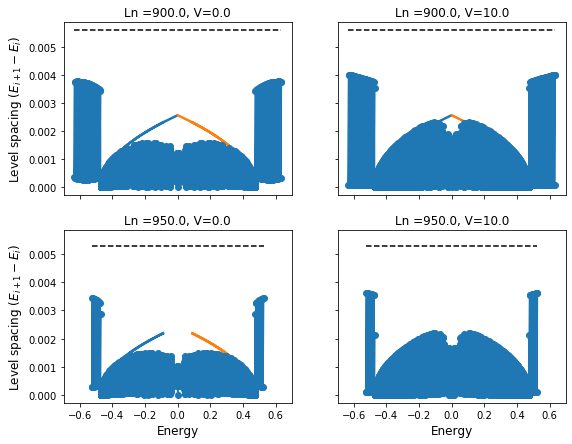

In [58]:
fig, sub = plt.subplots(2,2, sharey=True, sharex=True, figsize=(9,7))

params = dict(t=2.0, alpha=1, Delta=5.0, mu_n=0.0, mu_sc=0.0, V=10, 
                       m0=8.0, theta=0.5, phi=0.2)

nn = len(Lnarr)
iV = 0
for jj in range(2):
    sub[1,jj].set_xlabel('Energy', fontsize=12)
    sub[jj,0].set_ylabel('Level spacing '+r'$(E_{i+1}-E_i)$', fontsize=12)
    for ii in range(2):
        Ln = Lnarr[2*jj]
        d_spacing_theory = 2*np.pi*params.get('t')*alat/Ln
        sub[jj,ii] = level_spacing(En=Enlist[2*jj+ii*len(Lnarr)][iV*ii,::], nwide=1030, dE_pred=d_spacing_theory,
                                   ax=sub[jj,ii], dE_func=shift_Efunc, npts=700)
        sub[jj,ii].set_title('Ln ='+str(Ln)+', V='+str(xlist[2*jj+ii*len(Lnarr)][iV*ii]))
        

In [59]:
def S_lplots(A,TT):
    n_pick = 0
    Slist = []
    n_total = len(A)
    n_hlf = int(0.5*n_total)
    
    for ii in range(0,5):
        Slist.append(S_diff(A[n_pick][ii,::], A[n_pick+n_hlf][-1,::], TT))
        
    for jj in range(0,n_hlf):
        Slist.append(S_diff(A[jj][1,::], A[jj+n_hlf][-1,::], TT))
        
    return np.array(Slist)

In [60]:
Stoadapt = partial(S_lplots, Enlist)

In [61]:
Stoadapt(1e-3)

array([-0.35313426, -0.35610826, -0.3664829 , -0.3680727 , -0.35964642,
       -0.35610826, -0.33892254, -0.33185476, -0.34343375, -0.35388694])

In [62]:
Tlow = 2e-5; Thigh=9e-1
learner = adaptive.Learner1D(Stoadapt, bounds=(Tlow,Thigh))
runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 0.03)
runner.live_info()

In [63]:
keys, output = get_data_sorted(learner)

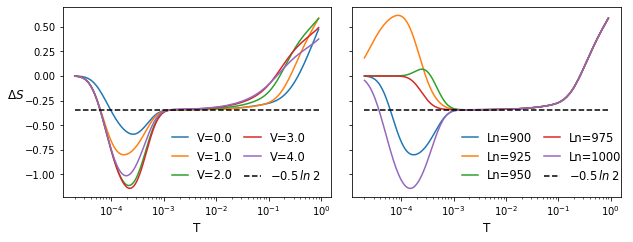

In [64]:
Tfewpoints = np.linspace(Tlow,Thigh,7)
fig, sub = plt.subplots(1,2, sharey=True, figsize=(10,3.5))

max_nV = 6
#for ii in range(len(sorted_output_discr[0,::])):
for ii in range(10):
    if ii < max_nV-1:
        sub[0].plot(keys, output[::,ii], label = 'V='+str(xlist[0][ii]))
    else:
        sub[1].plot(keys, output[::,ii], label = 'Ln='+str.format('{:.0f}',Lnarr[ii-max_nV+1]))
    
    
#sub[1].plot(Tfewpoints,-np.log(2)*np.ones(len(Tfewpoints)), '--b', label=r'$-ln\, 2$')
for ii in range(2):    
    sub[ii].set_xscale('log')
    sub[ii].plot(Tfewpoints,-0.5*np.log(2)*np.ones(len(Tfewpoints)), '--k', label=r'$-0.5\,ln\, 2$')
    sub[ii].set_xlabel('T', fontsize=12)
    #sub[ii].set_xlim(7e-4,2e-3)
    sub[ii].legend(loc=(0.39,0.05), frameon=False, fontsize=11.5, ncol=2, handlelength=1.4, columnspacing=1.0)    

sub[0].set_ylabel(r'$\Delta S$', fontsize=12, rotation='horizontal', labelpad=9)
fig.subplots_adjust(wspace=0.08)   

<a name="4"></a>
# Supplement

<a name="4.1"></a>
## Rashba nanowire within tight binding

In this section we provide more details of the level spacing function used in section Y

In [5]:
def Ksyst_Rash(aa,LS=None):
    
    def onsite(site, t, mu_n):
        return (2*t -mu_n)*tauz4
    
    def hop(site1, site2, t, alpha):
        return -t*tauz4 -1j*alpha*sy_tauz

    lat = kwant.lattice.chain(aa,norbs=4)

    if LS:
        def interval_shape(pos):
            x, = pos
            return  0 <= x <= LS 
    
        syst = kwant.Builder()
        syst[lat.shape(interval_shape, (0, ))] = onsite
        syst[lat.neighbors()] = hop
        syst = syst.finalized()
    
    else:
        build = kwant.Builder(kwant.TranslationalSymmetry([aa]))
        build[lat(0)] = onsite
        build[lat.neighbors()] = hop
        syst = kwant.wraparound.wraparound(build).finalized()
    
    return syst

The hamiltonian in the momentum space of a nanowire with strong spin-orbit coupling reads,
$$H(k)=-2t\cos{ka}-2\alpha\sin{ka}\,\sigma_y + 2t-\mu.$$

Let's obtain the low-$k$ hamiltonian around the local minima $\pm k'=\frac{1}{a}\tan^{-1}\bigl(\frac{\alpha}{t}\bigr)$, 

\begin{eqnarray}
H(k)&\approx& a^2t \cos{k'a}\,(k-k')^2 + 2at\sin{k'a}\,(k-k') \nonumber\\
&-&2\alpha\bigl\{\sin{k'a} + a\cos{k'a}\,(k-k')\bigr\}\sigma_y + 2t(1 - \cos{k'a}) -\mu. \nonumber
\end{eqnarray}

Diagonalization of the hamiltonian leads us to the energies,

\begin{eqnarray}
E(k)&=& ta^2(k\mp k')^2\cos{k'a} \pm 2a(k\mp k')\bigl\{t\sin{k'a} - \alpha\cos{k'a} \bigr\} \nonumber\\
&+& 2t(1 - \cos{k'a}) - 2\alpha\sin{k'a} -\mu. \nonumber
\end{eqnarray}

In [6]:
alat = 0.4
params = dict(t=2.0,mu_n=0.0,alpha=1.0)

In [15]:
def spectrum(hop,chem,socoup):
    
    Elist = []
    params['t'] = hop
    params['mu_n'] = chem
    params['alpha'] = socoup 
    tval = params.get('t')
    
    period_syst = Ksyst_Rash(alat)
    
    karr = np.linspace(-0.4*np.pi,0.4*np.pi,59)
    for kx in karr:
        params['k_x'] = kx
        ham = period_syst.hamiltonian_submatrix(params=params, sparse=False)
        Evals = eigh(ham, eigvals_only=True)
        Elist.append(Evals)

        Emtx = np.array(Elist)
    
    ak0 = np.arctan(socoup/hop)
    
    Eone = hop*np.cos(ak0)*(karr-ak0)**2 + 2*(hop*np.sin(ak0) - socoup*np.cos(ak0))*(karr-ak0) + \
    2*hop*(1 - np.cos(ak0)) - 2*socoup*np.sin(ak0) - chem 
    Etwo = hop*np.cos(ak0)*(karr+ak0)**2 - 2*(hop*np.sin(ak0) - socoup*np.cos(ak0))*(karr+ak0) + \
    2*hop*(1 - np.cos(ak0)) - 2*socoup*np.sin(ak0) - chem

    
    fig, sub = plt.subplots(1, figsize=(5,4))

    sub.plot(karr,Emtx)
    #sub.plot(k0*np.ones(7),np.linspace(-8,8,7), '--k')
    sub.plot(karr[::3],-Eone[::3], 'o', color='k', fillstyle='bottom', markersize=9)
    sub.plot(karr[::3],-Etwo[::3], 's', color='k', fillstyle='bottom', markersize=9)
    
    
#    sub.set_title(r'$\mu/t=$'+str(chem)+r'$,\,\Delta/t=$'+str(supgap))
    sub.set_xlabel(r'$ka$', fontsize=13)    
    sub.set_ylabel(r'$E$', fontsize=13)
    if abs(chem) <= 0.5:
        sub.set_ylim(-Eone[0],Eone[0])
    else:
        sub.set_ylim(-2.5*abs(chem),2.0*abs(chem))

    sub.legend(['kwant','  :','  :','  :','analytics','  :'],frameon=False, ncol=2, loc=8)

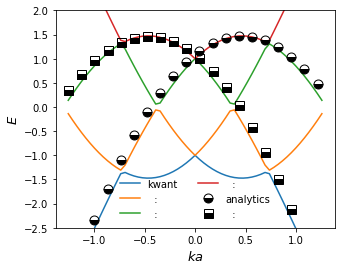

In [16]:
spectrum(hop=2.0, chem=1.0, socoup=1.0)

In [69]:
from ipywidgets import interactive

In [70]:
w = interactive(spectrum, hop=(0.5,3.5), chem=(-1.0,3.0), socoup=(0.0,2.0))
display(w)

interactive(children=(FloatSlider(value=2.0, description='hop', max=3.5, min=0.5), FloatSlider(value=1.0, desc…

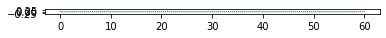

Plotting the nodes and vertices of the lattice


In [71]:
Ln = 60.0
alat = 0.4
syst_three = Ksyst_Rash(alat,Ln)
kwant.plot(syst_three)
print('Plotting the nodes and vertices of the lattice')

In [72]:
print(params)

{'t': 2.0, 'mu_n': 1.0, 'alpha': 1.0, 'k_x': 1.2566370614359172}


For a finite nanowire with boundary conditions $\psi(x=0)=\psi(x=L)=0$, the wave vector becomes $k=n\pi/L$, and  the energy

\begin{eqnarray}
E_n&=& ta^2\bigl(\frac{n\pi}{L}\mp k'\bigr)^2\cos{k'a} 
\pm 2a\bigl(\frac{n\pi}{L}\mp k'\bigr)\bigl\{t\sin{k'a} - \alpha\cos{k'a} \bigr\} \nonumber\\
&+& 2t(1 - \cos{k'a}) - 2\alpha\sin{k'a} -\mu. \nonumber
\end{eqnarray}

An analytic expression for the phase shift is lengthy so it will be calculated numerically in function `shift_Efunc()`

In [73]:
ham = syst_three.hamiltonian_submatrix(params=params, sparse=False)
evals = eigh(ham, eigvals_only=True)
evals = np.sort(evals)
print('Number of eigenvalues: ',len(evals))

Number of eigenvalues:  604


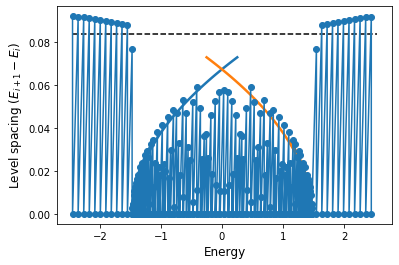

In [74]:
d_spacing_est = 2*np.pi*alat*(params.get('t'))/Ln
level_spacing(En=evals, nwide=140, dE_pred=d_spacing_est, dE_func=shift_Efunc, npts=70)